# Refine labels for Memory B cells

In this notebook, we load all Memory and Effector B cells across our subjects to refine final L3 labels. We'll combine, recluster, and assign final labels by taking the most frequent AIFI_L3 label in each cluster, and back-propogate those L3 labels to L2 and L1 based on our cell type hierarcy.

We'll also generate metadata, UMAP coordinates, and marker gene summaries for review of our final labels, then store all of the outputs in HISE for later use.

## Load packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
class_name = 'b_memory_cells'

## Helper functions

### HISE data
These functions make it easy to utilize files from the HISE cache

In [4]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [5]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

### Label refinement

This function uses the most frequent label within each cluster to refine label assignments.

In [7]:
def single_value(series):
    res = []
    for value in series:
        if isinstance(value, list):
            res.append(value[0])
        else:
            res.append(value)
    return res

In [8]:
def assign_most_frequent(adata, clusters, labels, keep_original = False, original_prefix = 'predicted_'):
    obs = adata.obs
    
    most_frequent_labels = (
        adata.obs
        .groupby(clusters)[labels]
        .agg(pd.Series.mode)
        .to_frame()
        .reset_index()
    )
    most_frequent_labels[labels] = single_value(most_frequent_labels[labels])
    
    if keep_original:
        obs = obs.rename({labels: original_prefix + labels}, axis = 1)
    else:
        obs = obs.drop(labels, axis = 1)
    
    obs = obs.merge(most_frequent_labels, on = clusters, how = 'left')
    
    adata.obs = obs
    
    return adata

This function back-propagates hierarchical labeling from AIFI_L3 back to AIFI_L2 and AIFI_L1 to ensure our labels agree across levels of our cell type hierarchy.

In [36]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
    
    adata.obs = obs

    return adata

### Review outputs

These functions are used to assemble marker gene expression tables for review

In [10]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def marker_mean_df(adata, markers, log = False, clusters = 'louvain_2'):
    gene_cl_mean = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True,
        log = log
    ).dot_color_df
    
    return gene_cl_mean

def tidy_marker_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, markers, clusters)
    gene_cl_frac = gene_cl_frac.reset_index(drop = False)
    gene_cl_frac = pd.melt(gene_cl_frac, id_vars = clusters, var_name = 'gene', value_name = 'gene_frac')
    
    gene_cl_mean = marker_mean_df(adata, markers, log = False, clusters = clusters)
    gene_cl_mean = gene_cl_mean.reset_index(drop = False)
    gene_cl_mean = pd.melt(gene_cl_mean, id_vars = clusters, var_name = 'gene', value_name = 'gene_mean')

    marker_df = gene_cl_frac.merge(gene_cl_mean, on = [clusters, 'gene'], how = 'left')
    return marker_df

This function uses marker fractions to select clusters based on a gene detection cutoff:

In [11]:
def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

This function retrieves both observations and UMAP coordinates in a single table for review.

In [12]:
def obs_with_umap(adata):
    obs = adata.obs
    
    umap_mat = adata.obsm['X_umap']
    umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
    obs['umap_1'] = umap_df['umap_1']
    obs['umap_2'] = umap_df['umap_2']

    return obs

### scRNA-seq data processing

This function applies data analysis methods to our scRNA-seq data, including normalization, HVG selection, PCA, nearest neighbors, UMAP, and Leiden clustering.

In [13]:
def process_adata(adata, filter_genes, resolution = 3):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()
    filtered_genes = [gene for gene in adata.var_names if gene not in filter_genes]
    adata = adata[:, filtered_genes]
    
    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')

    print('Harmony', end = "; ")
    # Integrate subjects
    sce.pp.harmony_integrate(
        adata, 
        'batch_id',
        max_iter_harmony = 30,
        verbose = False
    )
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 30,
        n_pcs = 30,
        use_rep = 'X_pca_harmony'
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 5
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

This function is used to update labels based on iterative clustering results

In [14]:
def label_substitution(adata, labels):
    sub_idx = adata.obs['barcodes'].isin(labels['barcodes'])
    sub_adata = adata[sub_idx]
    
    adata = adata[[not x for x in sub_idx]]
    
    sub_obs = sub_adata.obs.drop(['AIFI_L3', 'predicted_AIFI_L3'], axis = 1)
    sub_obs = sub_obs.reset_index(drop = True)
    sub_obs = sub_obs.merge(labels, on = 'barcodes', how = 'left')
    sub_obs = sub_obs.set_index('barcodes', drop = False)
    sub_adata.obs = sub_obs
    
    adata = sc.concat([adata, sub_adata])
    return adata

## Read cell type hierarchy from HISE

As part of label refinement, we'll back-propagate our cell type labels from refined AIFI_L3 labels to their parent cell classes at AIFI_L2 and AIFI_L1. To do this, we need the hierarchical relationships between these levels, which have been generated for our cell type reference dataset.

In [15]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files in HISE

For this analysis, we'll read in these files from HISE storage from previous steps. We'll group these into "large" files, which are from the set of 5 very large cell type assignments, and "small" files, which are from other cell types.

In [16]:
h5ad_uuids = {
    'Memory-B-cell': '38977bd9-bb58-491d-a293-c8a83585b21a',
    'Effector-B-cell': '6d849b19-68be-4243-807a-9ee59e6c962a'
}

## Read and assemble datasets

Now, we can read in the data from small sets to memory so that splitting them up for analysis is more efficient.

For large sets, we'll read files in selectively based on their metadata group to limit the amount of memory we utilize.

In [17]:
adata_dict = {}
for group_name, uuid in h5ad_uuids.items():
    adata_dict[group_name] = read_adata_uuid(uuid)

In [18]:
adata = sc.concat(adata_dict)

## Filter Ig Genes

For Memory and effector B cells, we want to focus on functional cell types, rather than Ig isotypes. To enable this, we'll filter Ig genes as part of our data processing.

In [19]:
igl_genes = [gene for gene in adata.var_names if gene.startswith("IGL")]
igk_genes = [gene for gene in adata.var_names if gene.startswith("IGK")]
ighc_genes = [gene for gene in adata.var_names if gene.startswith("IGH")]
exl_genes = igl_genes + igk_genes + ighc_genes

## Process data

Here, we'll process all of our cells together for clustering and review.

In [20]:
out_h5ad = out_file = 'output/diha_{c}_AIFI_L3_review_{d}.h5ad'.format(
    c = class_name,
    d = date.today()
)

In [21]:
adata = process_adata(
    adata,
    filter_genes = exl_genes,
    resolution = 3
)

Normalizing; Finding HVGs; Scaling; 

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


PCA; Harmony; 

2024-04-01 23:42:45,919 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-01 23:45:02,764 - harmonypy - INFO - sklearn.KMeans initialization complete.


Neighbors; Leiden; UMAP; Renormalizing


## Refine Early memory B cells

Early memory B cells are difficult to cluster and label in the full context of memory B cells due to their similarity to our Core memory B cells. However, we can identify them if we subset our cells as IGHD-positive and CXCR4-positive (To distinguish from more mature cells) and CD72-negative (to distinguish from Effector cells).

Within this subset of IGHD+/CXCR4+/CD72- cells, we can then iterate our clustering analysis and identify Early memory B cells through expression of the gene STAG3, which is a cohesin subunit involved in cell division.

Here, we'll use these markers to subset and identify Early memory B cells, which we'll transfer back onto our full Memory B cell dataset later in this notebook.

Identify positive clusters for each marker:

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


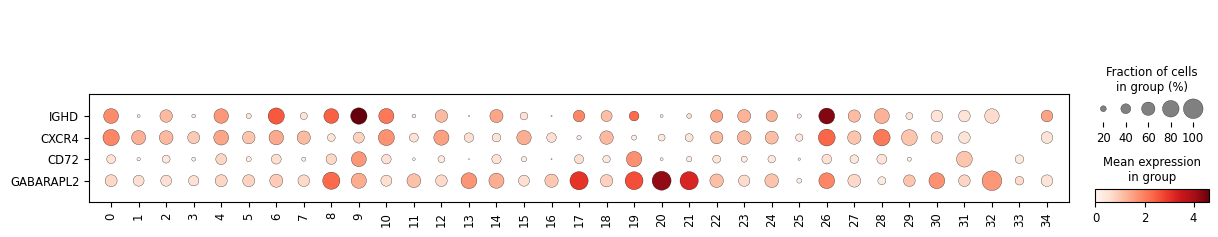

In [22]:
sc.pl.dotplot(
    adata, 
    groupby = 'leiden_3', 
    var_names = ['IGHD','CXCR4','CD72','GABARAPL2'], 
    swap_axes = True
)

In [23]:
ighd_pos_cl = select_clusters_above_gene_frac(adata, 'IGHD', 0.4, clusters = 'leiden_3')
cxcr4_pos_cl = select_clusters_above_gene_frac(adata, 'CXCR4', 0.2, clusters = 'leiden_3')
cd72_pos_cl = select_clusters_above_gene_frac(adata, 'CD72', 0.6, clusters = 'leiden_3')
gabarapl2_pos_cl = select_clusters_above_gene_frac(adata, 'GABARAPL2', 0.6, clusters = 'leiden_3')

Logic to identify IGHD+/CXCR4+/CD72-:

In [24]:
sel_cl = set(ighd_pos_cl).intersection(set(cxcr4_pos_cl))
sel_cl = sel_cl - set(cd72_pos_cl)
sel_cl = sel_cl - set(gabarapl2_pos_cl)
sel_cl = list(sel_cl)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


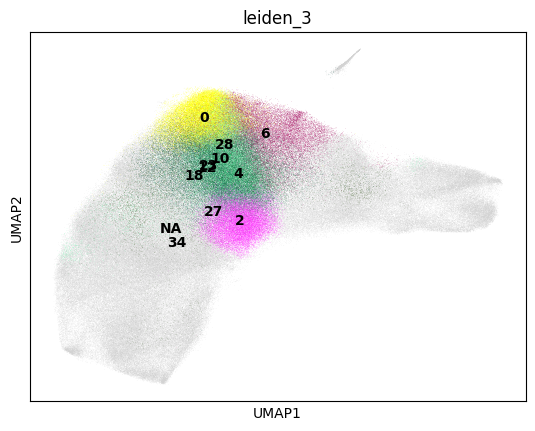

In [25]:
sc.pl.umap(adata, color = 'leiden_3', groups = sel_cl, legend_loc = 'on data')

Subset data to the selected clusters:

In [26]:
sub_adata = adata[adata.obs['leiden_3'].isin(sel_cl)]

Iteratively cluster this subset:

In [27]:
sub_adata = process_adata(sub_adata, filter_genes = [], resolution = 2)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; 

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


PCA; 

2024-04-02 00:19:10,749 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Harmony; 

2024-04-02 00:20:17,389 - harmonypy - INFO - sklearn.KMeans initialization complete.


Neighbors; Leiden; UMAP; Renormalizing


Identify and assign Early memory B cell labels to the STAG3-expressing cells

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


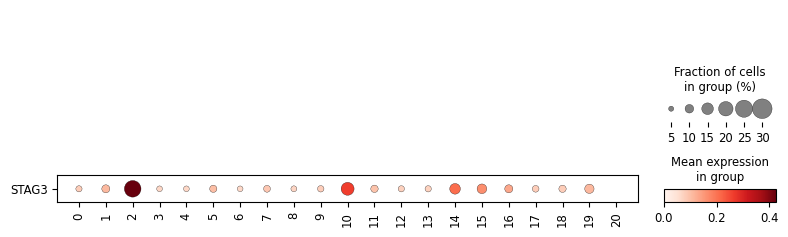

In [28]:
sc.pl.dotplot(
    sub_adata, 
    groupby = 'leiden_2', 
    var_names = 'STAG3', 
    swap_axes = True
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


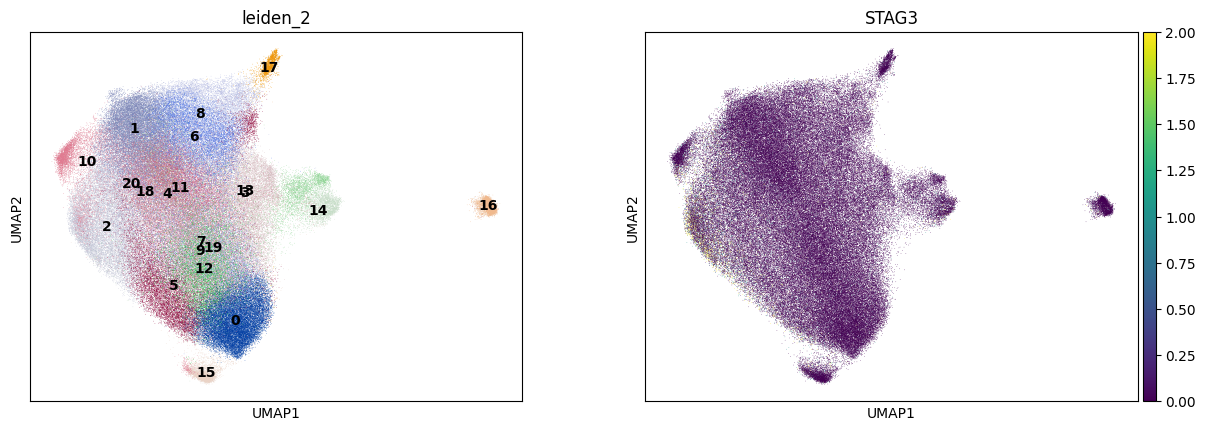

In [35]:
sc.pl.umap(
    sub_adata, 
    color = ['leiden_2', 'STAG3'], 
    vmax = 'p99', 
    legend_loc = 'on data')

In [30]:
stag3_pos_cl = select_clusters_above_gene_frac(sub_adata, 'STAG3', 0.2, clusters = 'leiden_2')
stag3_pos_cl

['2']

Get the barcodes for our Early memory B cells:

In [31]:
early_mem_bc = sub_adata.obs['barcodes'].loc[sub_adata.obs['leiden_2'].isin(stag3_pos_cl)]

## Refine labels based on clusters and Early memory identification

Here, we'll use the most frequent label in each original cluster to assign cell type labels, and substitute Early memory B cells for those we identified based on subclustering

In [32]:
adata = assign_most_frequent(
    adata, 
    'leiden_3', 'AIFI_L3', 
    keep_original = True,
    original_prefix = 'predicted_'
)

In [33]:
adata.obs['AIFI_L3'].loc[adata.obs['barcodes'].isin(early_mem_bc)] = 'Early memory B cell'

/tmp/ipykernel_4875/879396995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['AIFI_L3'].loc[adata.obs['barcodes'].isin(early_mem_bc)] = 'Early memory B cell'


In [37]:
adata = propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


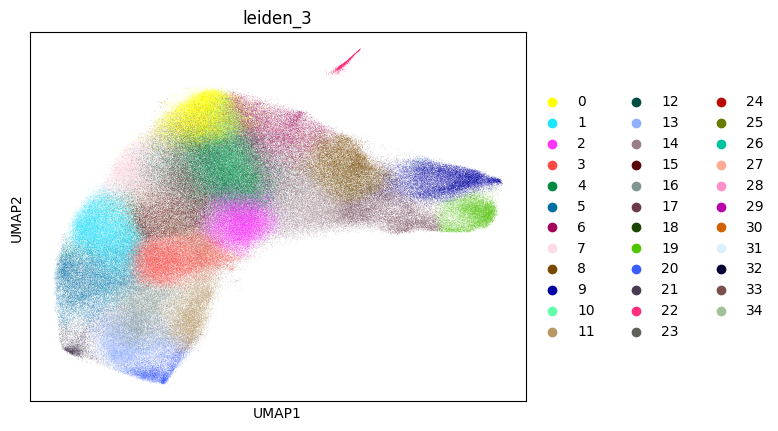

In [38]:
sc.pl.umap(adata, color = 'leiden_3')

**CellTypist Labels**

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


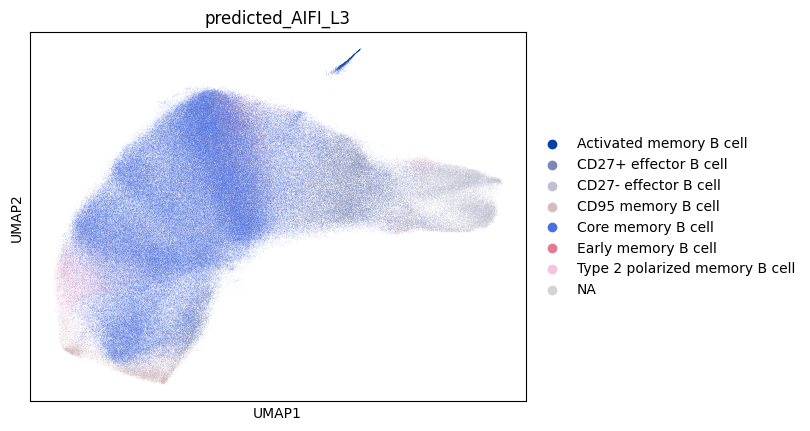

In [39]:
l3_groups = hierarchy_df['AIFI_L3'][
    hierarchy_df['AIFI_L2']
    .isin(['Memory B cell', 'Effector B cell'])
].tolist()
sc.pl.umap(
    adata, 
    color = 'predicted_AIFI_L3',
    groups = l3_groups
)

**Refined Labels**

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


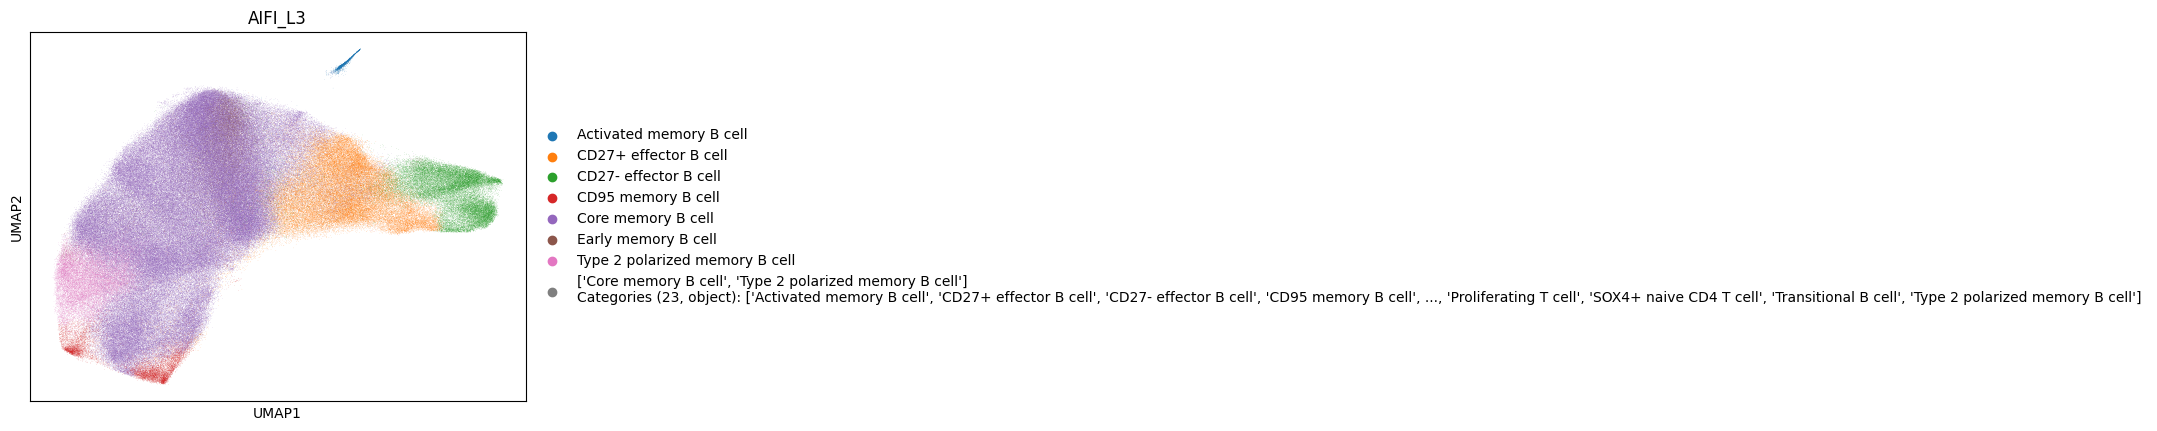

In [40]:
sc.pl.umap(adata, color = 'AIFI_L3')

## Write Outputs to disk

### AnnData object

In [41]:
adata.write_h5ad(out_h5ad)

### Cell metadata and UMAP Coordinates

In [42]:
out_meta = 'output/diha_{c}_AIFI_L3_review_meta_{d}.csv'.format(
    c = class_name,
    d = date.today()
)

In [43]:
obs = obs_with_umap(adata)
obs.to_csv(out_meta)

### Marker gene expression summaries

In [44]:
l2_markers = [
    'AIM2', 'CD24', 'CD27', 'CD83', 'CD44',
    'CD9', 'IGHD', 'ITGAX', 'MEF2C', 'MME', 
    'MZB1', 'PRDM1', 'TBX21', 'XBP1'
]

In [45]:
out_l2_markers = 'output/diha_{c}_AIFI_L2_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l2_marker_df = tidy_marker_df(
    adata,
    l2_markers,
    'AIFI_L2'
)
l2_marker_df.to_csv(out_l2_markers)

In [46]:
l3_markers = [
    'AIM2', 'CD27', 'CD69', 'CD79B', 'COCH',
    'FAS', 'FCER2', 'FCGR2B', 'FOS', 'IFI44L',
    'IGHD', 'IGHE', 'IGHM', 'IL4R', 'ISG15',
    'ITGAX', 'JUN', 'MEF2C', 'MYC', 'STAT1',
    'STAG3'
]

In [47]:
out_l3_markers = 'output/diha_{c}_AIFI_L3_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l3_marker_df = tidy_marker_df(
    adata,
    l3_markers,
    'AIFI_L3'
)
l3_marker_df.to_csv(out_l3_markers)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [48]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA Memory B cell L3 Label Refinement {d}'.format(d = date.today())

In [49]:
in_files = list(h5ad_uuids.values())
in_files

['38977bd9-bb58-491d-a293-c8a83585b21a',
 '6d849b19-68be-4243-807a-9ee59e6c962a']

In [50]:
out_files = [out_h5ad, out_meta, out_l2_markers, out_l3_markers]

In [51]:
out_files

['output/diha_b_memory_cells_AIFI_L3_review_2024-04-01.h5ad',
 'output/diha_b_memory_cells_AIFI_L3_review_meta_2024-04-02.csv',
 'output/diha_b_memory_cells_AIFI_L2_review_markers_2024-04-02.csv',
 'output/diha_b_memory_cells_AIFI_L3_review_markers_2024-04-02.csv']

In [52]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/diha_b_memory_cells_AIFI_L3_review_2024-04-01.h5ad
output/diha_b_memory_cells_AIFI_L3_review_meta_2024-04-02.csv
output/diha_b_memory_cells_AIFI_L2_review_markers_2024-04-02.csv
output/diha_b_memory_cells_AIFI_L3_review_markers_2024-04-02.csv
you are trying to upload file_ids... ['output/diha_b_memory_cells_AIFI_L3_review_2024-04-01.h5ad', 'output/diha_b_memory_cells_AIFI_L3_review_meta_2024-04-02.csv', 'output/diha_b_memory_cells_AIFI_L2_review_markers_2024-04-02.csv', 'output/diha_b_memory_cells_AIFI_L3_review_markers_2024-04-02.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'ccb4e65f-446e-4b39-83eb-bf840b1bfc49',
 'files': ['output/diha_b_memory_cells_AIFI_L3_review_2024-04-01.h5ad',
  'output/diha_b_memory_cells_AIFI_L3_review_meta_2024-04-02.csv',
  'output/diha_b_memory_cells_AIFI_L2_review_markers_2024-04-02.csv',
  'output/diha_b_memory_cells_AIFI_L3_review_markers_2024-04-02.csv']}

In [53]:
import session_info
session_info.show()